$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 20165549\ \ JANG\ \ JAE\ \ YONG$$

Build a binary classifier based on 3 layers neural network using the human versus horse dataset

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import math

import pandas as pd
import seaborn as sns

class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100*100
        _num1           = 50
        _num2           = 10
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, num_classes, bias=True)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.ReLU(True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.ReLU(True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.Sigmoid())
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2, self.fc_layer3)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):

        for m in self.modules():
            n1 = m.fc1.in_features
            m.fc1.weight.data.uniform_(- 1.0 / math.sqrt(n1/2), 1.0 / math.sqrt(n1/2))
            n2 = m.fc2.in_features
            m.fc2.weight.data.uniform_(- 1.0 / math.sqrt(n2/2), 1.0 / math.sqrt(n2/2))
            n3 = m.fc3.in_features
            m.fc3.weight.data.uniform_(- 1.0 / math.sqrt(n3), 1.0 / math.sqrt(n3))
            
            if m.fc1.bias is not None:
                m.fc1.bias.data.zero_()
            if m.fc2.bias is not None:
                m.fc2.bias.data.zero_()
            if m.fc3.bias is not None:
                m.fc3.bias.data.zero_()

            break
            
#         for m in self.modules():
#             n = m.in_features
#             m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))

#             if m.bias is not None:

#                 m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [7]:
# -----------------------------------------------------------------------------
# import packages
# -----------------------------------------------------------------------------
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import os
import numpy as np
import time
import datetime 
import csv
import configparser
import argparse
import platform

from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

# -----------------------------------------------------------------------------
# load dataset
# -----------------------------------------------------------------------------

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),
    # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100]
    # (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of train data set'
train_data_path = 'horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=1)  

#validation_data_path = 'relative path of validation data set'
validation_data_path = 'horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=50, shuffle=True, num_workers=1)  

set_train   = trainloader
set_test    = valloader

num_classes = 2
learningRate = 0.01

# -----------------------------------------------------------------------------
# load neural network model
# -----------------------------------------------------------------------------

# from Linear import *
model = Linear(num_classes=num_classes)

# -----------------------------------------------------------------------------
# Set the flag for using cuda
# -----------------------------------------------------------------------------

bCuda = 1

if bCuda:
 
    model.cuda()

# -----------------------------------------------------------------------------
# optimization algorithm
# -----------------------------------------------------------------------------

optimizer   = optim.SGD(model.parameters(), lr=learningRate, weight_decay = 1e-2)
objective   = nn.CrossEntropyLoss()

# -----------------------------------------------------------------------------
# function for training the model
# -----------------------------------------------------------------------------

def train():

    loader_train = set_train
    # print('train the model at given epoch')

    loss_train          = []
    correct         = 0
    model.train()
   
    for idx_batch, (data, target) in enumerate(loader_train):
       
        if bCuda:      
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
        loss_train.append(loss_train_batch)
        
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss_train_mean     = np.mean(loss_train)
    loss_train_std      = np.std(loss_train)
    accuracy_train   = 100. * float(correct) / len(loader_train.dataset)

    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std, 'accuracy_train' : accuracy_train}

# -----------------------------------------------------------------------------
# function for testing the model
# -----------------------------------------------------------------------------

def test():

    loader_test = set_test
    # print('test the model at given epoch')
    
    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):

        if bCuda:
            data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test / len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

# -----------------------------------------------------------------------------
#  Adjust learning rate
# -----------------------------------------------------------------------------

def adjust_lr(optimizer, epoch, learning_rate): 
    if epoch%10 == 0 and epoch != 0:
        learning_rate*= 0.6
        for param_group in optimizer.param_groups: 
            param_group['lr'] = learning_rate

# -----------------------------------------------------------------------------
# iteration for the epoch
# -----------------------------------------------------------------------------

epoch = 200

loss_train_mean = np.zeros(epoch, dtype=float)
loss_train_std = np.zeros(epoch, dtype=float)
loss_test = np.zeros(epoch, dtype=float)
accuracy_train = np.zeros(epoch, dtype=float)
accuracy_test = np.zeros(epoch, dtype=float)


for e in range(epoch):
    
    adjust_lr(optimizer, e, learningRate)
   
    result_train    = train()
    result_test     = test()

    loss_train_mean[e]  = result_train['loss_train_mean']
    loss_train_std[e]   = result_train['loss_train_std']
    loss_test[e]        = result_test['loss_test']
    
    accuracy_train[e]   = result_train['accuracy_train']
    accuracy_test[e]    = result_test['accuracy_test']
    
    print("[epoch {0}] loss: (training) {1}, (testing) {2}, accuracy: (training) {3}, (testing) {4}"\
          .format(e, round(loss_train_mean[e], 6), round(loss_test[e], 6),\
                  round(accuracy_train[e], 4), round(accuracy_test[e], 10)))

Plot the average of the training loss within the mini-batch cross iterations

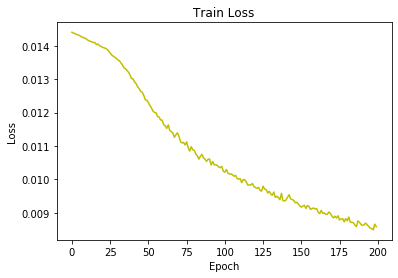

In [10]:
x = range(epoch)
y = loss_train_mean[x]

plt.plot(x, y, color='y')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Plot the standard deviation of the training loss withint the mini-batch cross iterations

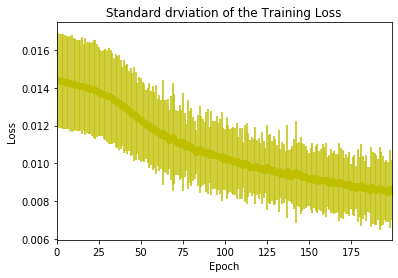

In [11]:
x = range(epoch)
y = sns.tsplot(data=loss_train_mean[x], err_style="unit_traces", color='y')
std  = loss_train_std
y.errorbar(range(epoch), loss_train_mean[x], yerr=std, fmt='-o', color='y')
plt.title('Standard drviation of the Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Plot the testing loss at each epoch

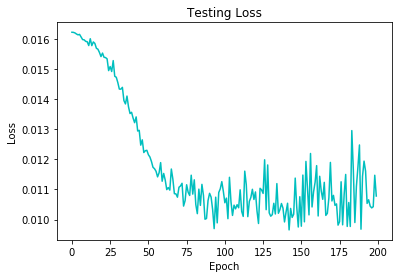

In [12]:
x = range(epoch)
y = loss_test[x]

plt.plot(x, y, color='c')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Plot the training and testing accuracy at each epoch

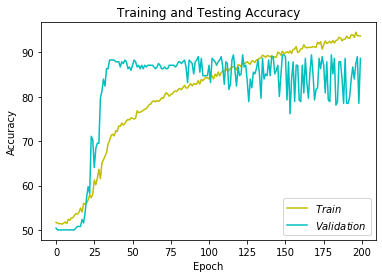

In [13]:
x = range(epoch)
y1 = accuracy_train[x]
y2 = accuracy_test[x]
plt.plot(x, y1, color='y', label='$Train$')
plt.plot(x, y2, color='c', label='$Validation$')
plt.legend(loc="lower right")
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [14]:
print()
idx1 = round(loss_train_mean[epoch - 1], 6)
idx2 = str(round(accuracy_train[epoch - 1], 10)) + ' %'
idx3 = round(loss_test[epoch - 1], 6)
idx4 = str(round(accuracy_test[epoch - 1], 10)) + ' %'

df = pd.DataFrame(data=np.array([[idx1, idx2], [idx3, idx4]]), index= ['Training', 'Validation'], columns=['Loss', 'Accuracy'])
display(df)

,Loss,Accuracy
Training,0.008579,93.6708860759 %
Validation,0.010782,88.671875 %


Markdown:

| Dataset | Loss | Accuracy |
|:--------|:--------:|--------:|
| Training | 0.008579 | 93.6708860759% |
| Validation | 0.010782 | 88.671875% |